# Merge Positve and Negative Samples

Notebook: Merging and Visualizing Negative Samples
Objective: Combine negative samples from blank area and other deposits at configurable ratios,
visualize spatial distribution, and prepare for final model training.

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point

In [3]:
# === CONFIGURABLE PARAMETERS ===
POSITIVE_PATH = "../data/processed/positive_augmented_patch.csv"
NEG_BLANK_PATH = "../data/processed/negative_blank_samples.csv"
NEG_OTHER_PATH = "../data/processed/negative_other_deposit_samples.csv"
EXPORT_PATH = "../data/processed/final_samples_balanced.csv"

In [4]:
RATIO_BLANK_TO_OTHER = 1.0  # e.g. 1.0 means 1:1 between blank and other deposit
NEGATIVE_TO_POSITIVE_RATIO = 2  # final dataset = pos : neg = 1 : 2

In [5]:
# === 1. Load Data ===
positive_df = pd.read_csv(POSITIVE_PATH)
neg_blank_df = pd.read_csv(NEG_BLANK_PATH)
neg_other_df = pd.read_csv(NEG_OTHER_PATH)

positive_df["LABEL"] = 1
neg_blank_df["LABEL"] = 0
neg_other_df["LABEL"] = 0

positive_df["SOURCE"] = "positive"
neg_blank_df["SOURCE"] = "blank_area"
neg_other_df["SOURCE"] = "other_deposit"

In [6]:
# === 2. Sample and Merge Negative Samples ===
n_pos = len(positive_df)
n_neg_total = NEGATIVE_TO_POSITIVE_RATIO * n_pos

# Calculate split
ratio_blank = RATIO_BLANK_TO_OTHER / (1 + RATIO_BLANK_TO_OTHER)
n_blank = int(n_neg_total * ratio_blank)
n_other = n_neg_total - n_blank

neg_blank_sampled = neg_blank_df.sample(n=min(n_blank, len(neg_blank_df)), random_state=42)
neg_other_sampled = neg_other_df.sample(n=min(n_other, len(neg_other_df)), random_state=42)

neg_combined = pd.concat([neg_blank_sampled, neg_other_sampled], ignore_index=True)

In [7]:
# === 3. Merge Final Dataset ===
df_final = pd.concat([positive_df, neg_combined], ignore_index=True)
df_final = df_final.sample(frac=1, random_state=42).reset_index(drop=True)

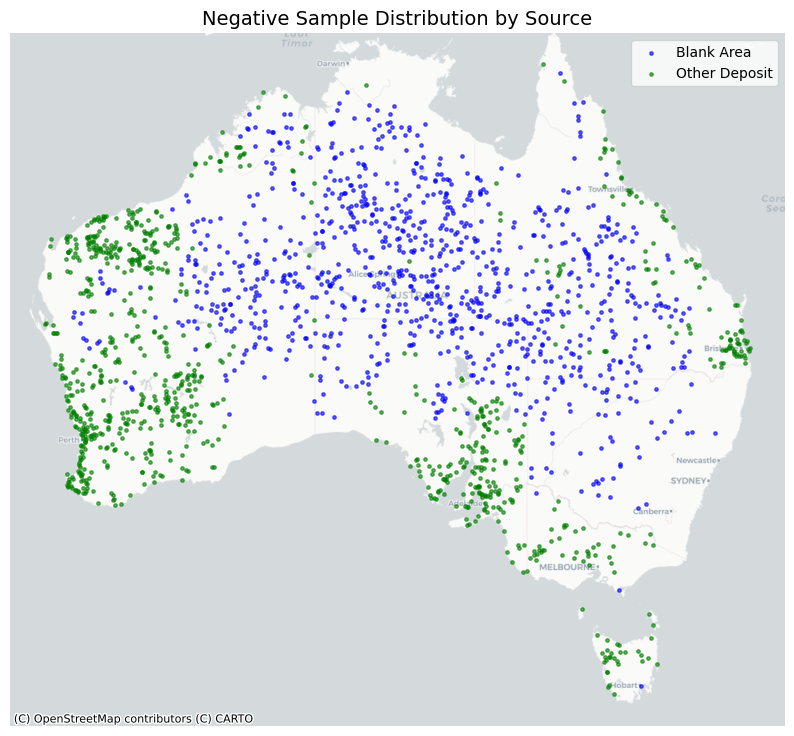

In [8]:
# === 4. Visualization ===
# Only plot negative samples for visual clarity
fig, ax = plt.subplots(figsize=(10, 12))

# Plot base map using Web Mercator
neg_gdf = gpd.GeoDataFrame(
    neg_combined,
    geometry=gpd.points_from_xy(neg_combined.LONGITUDE, neg_combined.LATITUDE),
    crs="EPSG:4326"
).to_crs(epsg=3857)

colors = {"blank_area": "blue", "other_deposit": "green"}

for src, group in neg_gdf.groupby("SOURCE"):
    group.plot(ax=ax, markersize=6, label=src.replace("_", " ").title(), color=colors[src], alpha=0.6)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title("Negative Sample Distribution by Source", fontsize=14)
ax.axis("off")
ax.legend()
plt.show()

In [10]:
# === 5. Export Final Dataset ===
df_final.to_csv(EXPORT_PATH, index=False)
print(f"✅ Final merged dataset saved to: {EXPORT_PATH}")

✅ Final merged dataset saved to: ../data/processed/final_samples_balanced.csv
